In [135]:
@__DIR__

"/global/u1/b/blaschke/NESAP/GB-25/analysis"

In [136]:
using TranscodingStreams, CodecZlib, JSON, Statistics, PrettyTables, Dates, Plots

In [137]:
prefix = "/pscratch/sd/b/blaschke/GB25/runs/"

"/pscratch/sd/b/blaschke/GB25/runs/"

In [138]:
function only_or_default(list, default)
    if length(list) == 0
        return default
    end
    only(list)
end

function only_or_default(default)::Function
    return function(list)
        return only_or_default(list, default)
    end
end

only_or_default (generic function with 2 methods)

In [139]:
function test_dir(ng::Int)::String
    nstr = lpad(ng, 5, "0")
    "ngpu=$(nstr)"
end

get_jobid(pth::String)::String = readdir(pth) |> 
    filter(endswith(".err"))                  |> 
    only_or_default("INVALID.drop")           |>
    Base.Fix2(split, ".")                     |>
    first

function profile_dir(root::String, jid::String, rank::Int; prof_dir::String="loop2")::String
    return joinpath(root, "profiling", "$(jid).$(rank)", prof_dir, "plugins", "profile")
end

function profile_for_job(pdir::String)::String
    ddir  = readdir(pdir) |> only_or_default("INVALID")

    tpath = joinpath(pdir, ddir) |> readdir |>
        Base.Fix1(filter, endswith(".trace.json.gz")) |>
        only_or_default("INVALID")
    
    if "INVALID" == ddir
        return ddir
    end
    
    joinpath(pdir, ddir, tpath)
end

function get_nccl_stats(pth::String)
    stream = GzipDecompressorStream(open(pth))
    tprof  = readchomp(stream) |> JSON.parse
    close(stream)

    nccl_events = tprof["traceEvents"] |> filter(x->"name" in keys(x) && contains(x["name"], "nccl"))

    nccl_stats = Dict()
    for event in nccl_events
        if !("name" in keys(event)) || !("dur" in keys(event))
            continue
        end
        push!(get!(nccl_stats, event["name"], []), event["dur"])
    end

    nccl_summary = Dict()
    for event_type in keys(nccl_stats)
        events = nccl_stats[event_type]
        nccl_summary[event_type] = (
            mean = mean(events),
            std  = std(events),
            sum  = sum(events),
            freq = length(events)
        )
    end

    nccl_summary, nccl_stats
end

function get_run_stats(pth::String)
    stream = GzipDecompressorStream(open(pth))
    tprof  = readchomp(stream) |> JSON.parse
    close(stream)

    run_stats = Dict()
    for event in tprof["traceEvents"]
        if !("name" in keys(event)) || !("dur" in keys(event))
            continue
        end
        push!(get!(run_stats, event["name"], []), event["dur"])
    end

    run_summary = Dict()
    for event_type in keys(run_stats)
        events = run_stats[event_type]
        run_summary[event_type] = (
            mean = mean(events),
            std  = std(events),
            sum  = sum(events),
            freq = length(events)
        )
    end

    run_summary, run_stats
end

get_run_stats (generic function with 1 method)

In [140]:
struct Run
    path::String
    time::DateTime
    sim::String
    ngpu::Vector{Int}
    prof::Vector{Int}
    ppath::Vector{String}
end

In [141]:
function summarize_run_dirs(prefix::String, pname::String)
    runs = readdir(prefix) |> Base.Fix1(map, Base.Fix1(joinpath, prefix)) |> filter(isdir)
    runs_by_type = Dict{String, Vector{Run}}()
    for run in runs
        sim_dir = readdir(run)
        
        sim = sim_dir |> filter(endswith(".jl"))
        if length(sim) != 1
            continue
        end
        sim = only(sim)
        
        r = splitpath(run) |> last
        d = split(r, ".") |> first |> Base.Fix2(DateTime, dateformat"yyyy-mm-ddTHH-MM-SS")
        t = sim_dir  |> filter(startswith("ngpu=")) |>
            Base.Fix1(map, x->last(split(x, "="))) |> Base.Fix1(map, Base.Fix1(parse, Int))
        p = Int[]
        pp = String[]
        for i in t
            jid   = get_jobid(joinpath(run, test_dir(i)))
            if "INVALID" == jid
                continue
            end
            
            pdir = profile_dir(joinpath(prefix, run), jid, 0; prof_dir=pname)
            if !ispath(pdir)
                continue
            end
            
            tpath = profile_for_job(pdir)
            if "INVALID" == tpath
                continue
            end
            push!(p, i)
            push!(pp, tpath)
        end
        
        push!(get!(runs_by_type, sim, []), Run(run, d, sim, t, p, pp))
    end
    runs_by_type
end

summarize_run_dirs (generic function with 1 method)

In [142]:
get_ngpu_columns(data) = map(x->x.ngpu, data) |> Base.Fix1(reduce, vcat) |> Set |> collect |> sort

function summary_table(data)
    ngpu = get_ngpu_columns(data)
    ngpu_h = get_ngpu_columns(data) |> Base.Fix1(map, string)
    header = vcat(["idx", "run"], ngpu_h)

    idx = collect(1:length(data))
    dates = map(x->x.time, data)
    paths = map(x->x.path, data)

    tdata = hcat(idx, paths)
    for n in ngpu
        z = zeros(Int, length(paths))
        for i = 1:length(z)
            if n in data[i].prof
                z[i] = 1
            end
        end
        tdata = hcat(tdata, z)
    end
    
    pretty_table(
        tdata;
        header = header,
        tf     = tf_unicode_rounded
    )
end

summary_table (generic function with 1 method)

In [143]:
valid_jobs = summarize_run_dirs(prefix, "loop2")
keys(valid_jobs)

KeySet for a Dict{String, Vector{Run}} with 2 entries. Keys:
  "sharded_baroclinic_instability_simulation_run.jl"
  "simple_sharding_problem.jl"

In [145]:
v = valid_jobs["simple_sharding_problem.jl"] |> filter(x->sum(x.prof)>0)
sort!(v, by=x->x.time, rev=true)
# summary_table(v[1:15])
summary_table(v)

╭─────┬────────────────────────────────────────────────────────────────┬───┬───┬────┬────┬────┬─────┬─────┬─────┬──────┬──────┬──────┬──────╮
│ idx │                                                            run │ 4 │ 8 │ 16 │ 32 │ 64 │ 128 │ 256 │ 512 │ 1024 │ 2048 │ 4096 │ 7000 │
├─────┼────────────────────────────────────────────────────────────────┼───┼───┼────┼────┼────┼─────┼─────┼─────┼──────┼──────┼──────┼──────┤
│   1 │ /pscratch/sd/b/blaschke/GB25/runs/2025-04-10T22-59-11.892_AKXo │ 0 │ 0 │  0 │  0 │  0 │   1 │   0 │   0 │    0 │    0 │    0 │    0 │
│   2 │ /pscratch/sd/b/blaschke/GB25/runs/2025-04-10T22-53-07.857_6dCC │ 1 │ 1 │  1 │  1 │  1 │   0 │   0 │   0 │    0 │    0 │    0 │    0 │
│   3 │ /pscratch/sd/b/blaschke/GB25/runs/2025-04-10T22-49-12.605_4Wt6 │ 1 │ 1 │  1 │  1 │  1 │   0 │   0 │   0 │    0 │    0 │    0 │    0 │
│   4 │ /pscratch/sd/b/blaschke/GB25/runs/2025-04-10T22-45-01.987_PkxR │ 1 │ 0 │  0 │  0 │  0 │   0 │   0 │   0 │    0 │    0 │    0 │    0 │
│   5 

In [11]:
run_metrics = Dict()

for elt in v[1:15]
    for ngpu in elt.prof
        jid   = get_jobid(joinpath(elt.path, test_dir(ngpu)))
        pdir  = profile_dir(elt.path, jid, 0; prof_dir="loop2")
        tpath = profile_for_job(pdir)
        st, _ = get_run_stats(tpath)
        for metric in keys(st)
            push!(
                get!(run_metrics, metric, []),
                (mean=st[metric].mean, sum=st[metric].sum, ngpu=ngpu)
            )
        end
    end
end

In [22]:
metric_keys = keys(run_metrics) |> collect

1138-element Vector{Any}:
 "wrapped_slice_105"
 "loop_select_fusion_16"
 "wrapped_slice_30"
 "loop_transpose_fusion_77"
 "wrapped_slice_69"
 "loop_transpose_fusion_97"
 "input_concatenate_transpose_fusion_1"
 "loop_concatenate_fusion_2_remat"
 "loop_dynamic_slice_fusion_17"
 "loop_slice_fusion_95"
 "loop_slice_fusion_77"
 "input_transpose_fusion_135"
 "wrapped_slice_25"
 ⋮
 "wrapped_slice_197"
 "loop_slice_fusion_38"
 "input_transpose_fusion_161"
 "wrapped_slice_95"
 "wrapped_slice_414"
 "loop_slice_fusion_64"
 "wrapped_slice_160"
 "wrapped_slice_68"
 "loop_select_fusion_7"
 "loop_select_fusion_29"
 "input_transpose_fusion_18"
 "wrapped_slice_342"

In [23]:
nccl_metrics = metric_keys |> filter(startswith("nccl"))

4-element Vector{Any}:
 "ncclDevKernel_AllGather_RING_LL(ncclDevKernelArgsStorage<4096ul>)"
 "ncclDevKernel_AllReduce_Sum_f64_TREE_LL(ncclDevKernelArgsStorage<4096ul>)"
 "ncclDevKernel_AllReduce_Sum_f64_RING_LL(ncclDevKernelArgsStorage<4096ul>)"
 "ncclDevKernel_SendRecv(ncclDevKernelArgsStorage<4096ul>)"

In [24]:
compute_slice_metrics = vcat(
    metric_keys |> filter(startswith("wrapped_slice")),
    metric_keys |> filter(startswith("input_slice"))
)
compute_loop_metrics = metric_keys |> filter(startswith("loop"))
compute_add_metrics = metric_keys |> filter(startswith("wrapped_add"))
compute_multiply_metrics = metric_keys |> filter(startswith("input_multiply_transpose"))
compute_concatenate_metrics = vcat(
    metric_keys |> filter(startswith("wrapped_concatenate")),
    metric_keys |> filter(startswith("input_concatenate"))
)
compute_transpose_metrics = vcat(
    metric_keys |> filter(startswith("input_transpose")),
    metric_keys |> filter(startswith("input_negate_transpose")),
    metric_keys |> filter(startswith("input_slice_transpose")),
    metric_keys |> filter(startswith("input_select_transpose")),
    metric_keys |> filter(startswith("input_compare_transpose_fusion"))   

)
compute_extra_metrics = vcat(
    metric_keys |> filter(startswith("Memset")),
    [
        "copy_fusion",
        "wrapped_transpose",
        "wrapped_compare"
    ]
)

compute_metrics = vcat(
    compute_slice_metrics,
    compute_loop_metrics,
    compute_add_metrics,
    compute_multiply_metrics,
    compute_concatenate_metrics,
    compute_transpose_metrics,
    compute_extra_metrics
)

cuda_api_metrics = [
    "cuStreamSynchronize",
    "MemcpyD2H",
    "MemcpyD2D"
]

cuda_api_memcpy_metrics = [
    "MemcpyD2H",
    "MemcpyD2D"
]

all_metrics = vcat(
    nccl_metrics,
    compute_metrics,
    cuda_api_memcpy_metrics,
    nccl_metrics
)

ignore_metrics = vcat(
    metric_keys |> filter(startswith("Wait")),
    metric_keys |> filter(startswith("ThreadpoolListener")),
    metric_keys |> filter(startswith("PjRtStreamExecutorLoadedExecutable")),
    metric_keys |> filter(startswith("Thunks")),
    metric_keys |> filter(startswith("reactant_loop_")),
    [
        "Rendezvous",
        "While",
        "RecordUsage",
        "LockGpuClique", 
        "MakeOutputBuffers",
        "Lockable::Lock::Acquire",
        "ThenExecuteCallback",
        "Build buffer allocations",
        "RendezvousAfterInitialization",
        "Build buffer allocations",
        "ExecuteRendezvousCallback",
        "BUFFER_FLUSH",
        "AcquireCollectiveCliques",
        "ComputeSemaphoreAcquire",
        "Resolve constant globals",
        "AcquireGpuClique",
        "<UNKNOWN>"
    ]
)

metric_keys |> 
    filter(x->!(x in compute_metrics)) |> 
    filter(x->!(x in nccl_metrics)) |> 
    filter(x->!(x in cuda_api_metrics)) |>
    filter(x->!(x in ignore_metrics))

Any[]

In [25]:
metric_names = Dict(
    "ncclDevKernel_AllReduce_Sum_f64_RING_LL(ncclDevKernelArgsStorage<4096ul>)" => "AllReduce_Sum_RING",
    "ncclDevKernel_AllReduce_Sum_f64_TREE_LL(ncclDevKernelArgsStorage<4096ul>)" => "AllReduce_Sum_TREE",
    "ncclDevKernel_SendRecv(ncclDevKernelArgsStorage<4096ul>)" => "SendRecv",
    "ncclDevKernel_AllGather_RING_LL(ncclDevKernelArgsStorage<4096ul>)" => "AllGather"
)

Dict{String, String} with 4 entries:
  "ncclDevKernel_AllReduce_Sum_f64_RING_LL(ncclDevKerne… => "AllReduce_Sum_RING"
  "ncclDevKernel_AllReduce_Sum_f64_TREE_LL(ncclDevKerne… => "AllReduce_Sum_TREE"
  "ncclDevKernel_SendRecv(ncclDevKernelArgsStorage<4096… => "SendRecv"
  "ncclDevKernel_AllGather_RING_LL(ncclDevKernelArgsSto… => "AllGather"

In [26]:
function sum_metrics(data, metrics)
    cm = Dict()
    
    for k in metrics
        d = data[k]
        x = map(x->x.ngpu, d)
        y = map(x->x.sum,  d)
        for (n, m) in zip(x, y)
            cm[n] = get!(cm, n, 0) + m
        end
    end
    
    x = cm |> keys |> collect |> sort
    y = map(x->cm[x], x)
    return x, y
end

sum_metrics (generic function with 1 method)

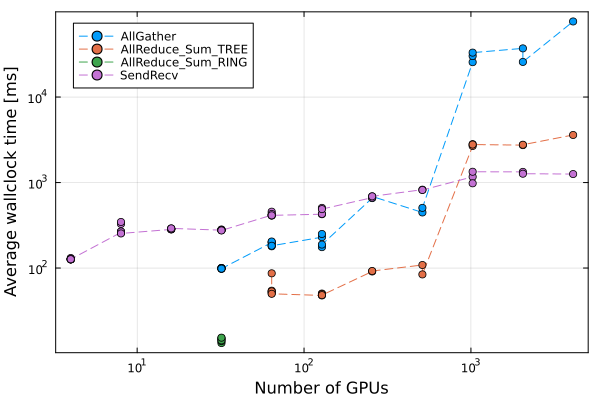

In [27]:
plot()
for k in nccl_metrics
    d = sort(run_metrics[k], by=x->x.ngpu)
    x = map(x->x.ngpu, d)
    y = map(x->x.mean, d)
    plot!(
        x, y, label=metric_names[k],
        markershape=:circle, linestyle=:dash
    )
end

plot!(
    xaxis=:log, yaxis=:log,
    framestyle=:box,
    xlabel="Number of GPUs",
    ylabel="Average wallclock time [ms]"
)

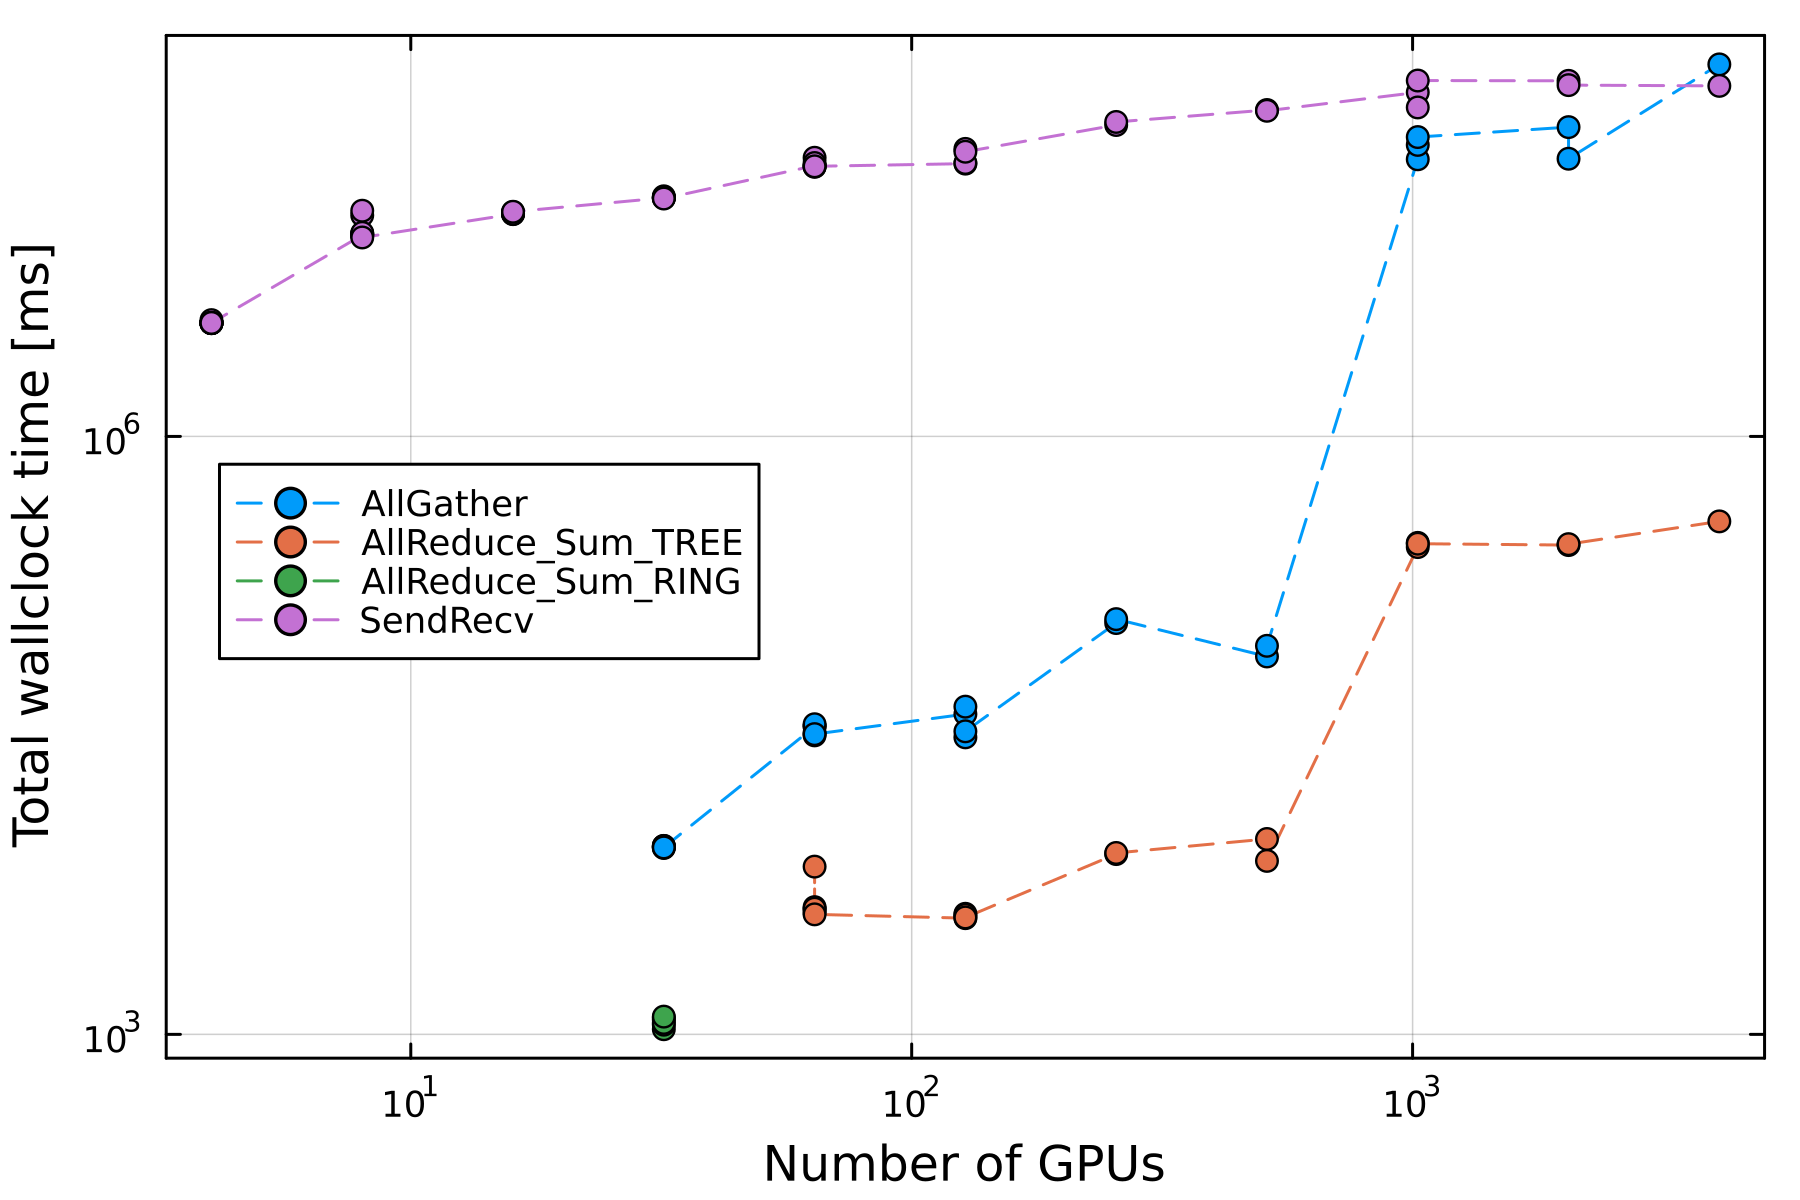

In [29]:
plot()
for k in nccl_metrics
    d = sort(run_metrics[k], by=x->x.ngpu)
    x = map(x->x.ngpu, d)
    y = map(x->x.sum,  d)
    plot!(
        x, y, label=metric_names[k],
        markershape=:circle, linestyle=:dash
    )
end

plot!(
    xaxis=:log, yaxis=:log,
    framestyle=:box,
    xlabel="Number of GPUs",
    ylabel="Total wallclock time [ms]",
    legend=:left,
    dpi=300
)

In [30]:
savefig("comms.png")

"/global/u1/b/blaschke/NESAP/GB-25/analysis/comms.png"

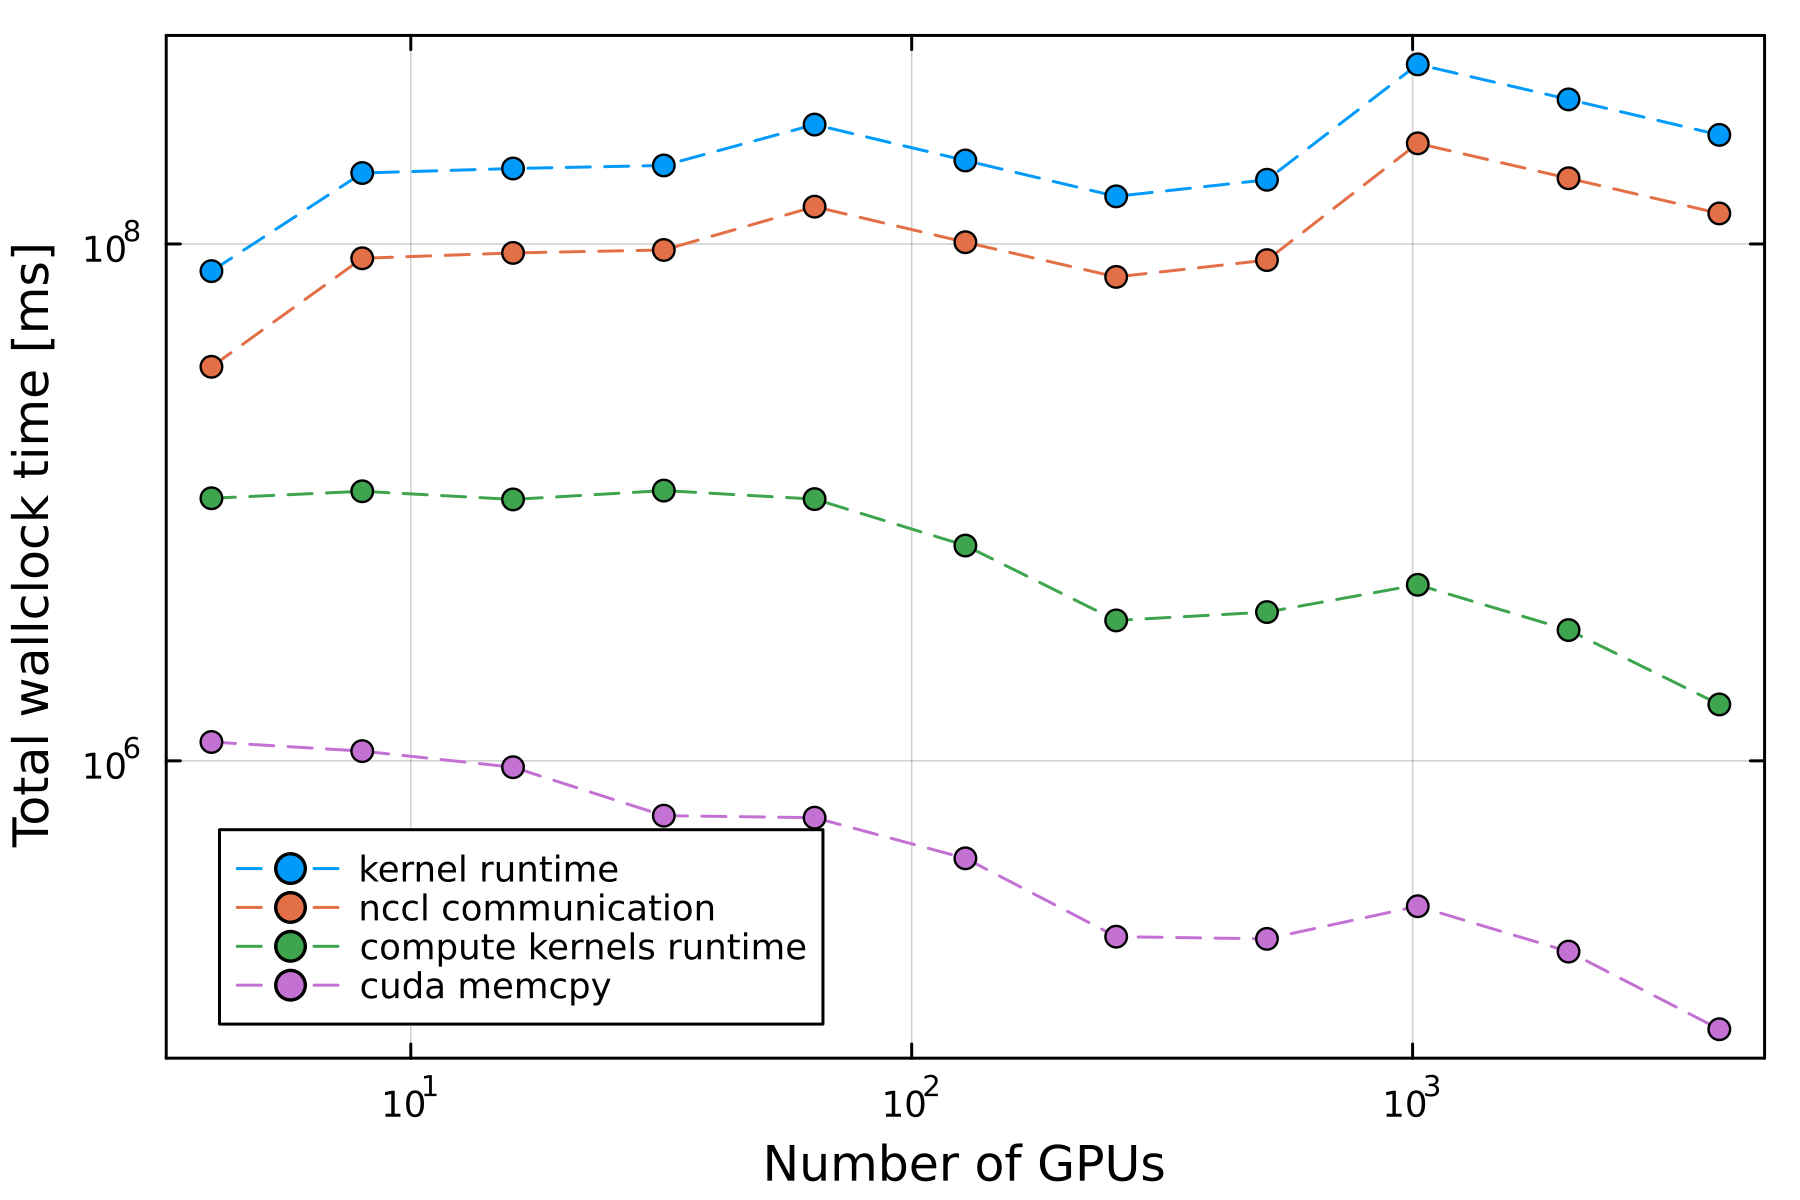

In [32]:
x, y = sum_metrics(run_metrics, all_metrics)
plot(
    x, y, label="kernel runtime",
    markershape=:circle, linestyle=:dash
)

x, y = sum_metrics(run_metrics, nccl_metrics)
plot!(
    x, y, label="nccl communication",
    markershape=:circle, linestyle=:dash
)

x, y = sum_metrics(run_metrics, compute_metrics)
plot!(
    x, y, label="compute kernels runtime",
    markershape=:circle, linestyle=:dash
)

x, y = sum_metrics(run_metrics, cuda_api_memcpy_metrics)
plot!(
    x, y, label="cuda memcpy",
    markershape=:circle, linestyle=:dash
)

plot!(
    xaxis=:log, yaxis=:log,
    framestyle=:box,
    xlabel="Number of GPUs",
    ylabel="Total wallclock time [ms]",
    legend=:bottomleft,
    dpi=300
)

In [33]:
savefig("weak_scaling_breakdown.png")

"/global/u1/b/blaschke/NESAP/GB-25/analysis/weak_scaling_breakdown.png"

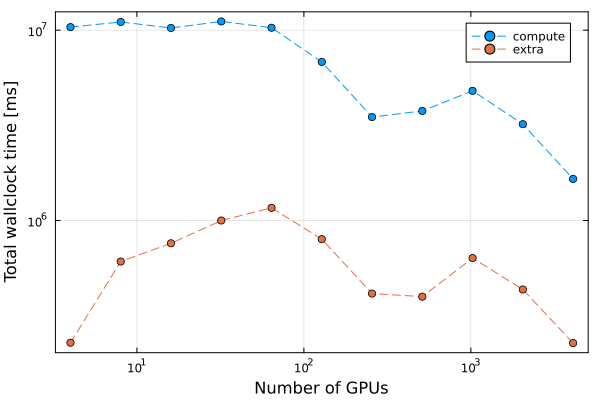

In [299]:
x, y = sum_metrics(run_metrics, compute_metrics)
plot(
    x, y, label="compute",
    markershape=:circle, linestyle=:dash
)

x, y = sum_metrics(run_metrics, compute_extra_metrics)
plot!(
    x, y, label="extra",
    markershape=:circle, linestyle=:dash
)

plot!(
    xaxis=:log, yaxis=:log,
    framestyle=:box,
    xlabel="Number of GPUs",
    ylabel="Total wallclock time [ms]"
)